In [65]:
!python -V


Python 3.9.7


In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso,Ridge
import pickle
import warnings
warnings.filterwarnings('ignore')

## INITIAL EXPERIMENTATION 

In [67]:
!pwd

/Users/subramanianhariharan/Documents/kumar_work/mlops/mlops-zoomcamp/notebooks


In [68]:
df = pd.read_parquet('/Users/subramanianhariharan/Documents/kumar_work/mlops/mlops-zoomcamp/data/green_tripdata_2021-01.parquet')

In [69]:
df.head(4)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00


In [70]:
df.shape

(76518, 20)

In [71]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [72]:
df.trip_type.value_counts()

1.0    39233
2.0     1238
Name: trip_type, dtype: int64

In [73]:
df['duration'] = df['lpep_dropoff_datetime']-df['lpep_pickup_datetime']

In [74]:
df.head(3)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58


In [75]:
df['duration'][0].total_seconds()

236.0

In [76]:
df['duration']=df['duration'].apply(lambda x : x.total_seconds()/60)

In [77]:
df['duration'].describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

<AxesSubplot:xlabel='duration', ylabel='Count'>

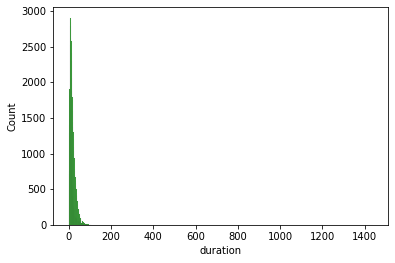

In [78]:
sns.histplot(df['duration'],color='g')

In [79]:
#df = df[df['trip_type']==2.0]

In [80]:
df.shape

(76518, 21)

In [81]:
df['duration'].describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

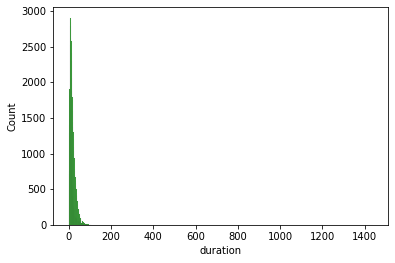

In [82]:
sns.histplot(df['duration'],color='g')
plt.show()

In [83]:
df= df[(df['duration']>=1.0) & (df['duration']<=60.0)]

In [84]:
df.shape

(73908, 21)

In [85]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [86]:
df[categorical] = df[categorical].astype(str)

In [87]:
df[categorical+numerical].iloc[:3].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12}]

In [88]:
train_dict = df[categorical+numerical].to_dict(orient='records')

In [89]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [91]:
y_train = df['duration'].values

In [109]:
def fit_model(model,X_train,y_train):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    rmse=mean_squared_error(y_train,y_pred,squared=False) #RMSE
    print(f'RMSE with {model} is {rmse}')
    sns.distplot(y_pred,label='prediction')
    sns.distplot(y_train,label='actual')
    plt.legend()
    plt.show()
    return None

RMSE with LinearRegression() is 9.838799799829626


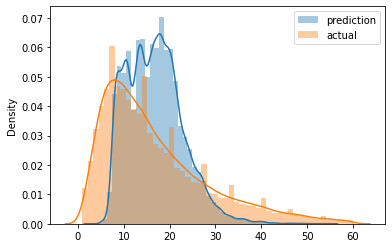

In [110]:
fit_model(LinearRegression(),X_train,y_train)

## MODULARIZE CODE

In [156]:
#function to read df and return processed df with filtered columns
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df['lpep_dropoff_datetime']-df['lpep_pickup_datetime']
    df['duration']=df['duration'].apply(lambda x : x.total_seconds()/60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df

In [157]:
df_train = read_dataframe('/Users/subramanianhariharan/Documents/kumar_work/mlops/mlops-zoomcamp/data/green_tripdata_2021-01.parquet')

In [117]:
df_valid = read_dataframe('/Users/subramanianhariharan/Documents/kumar_work/mlops/mlops-zoomcamp/data/green_tripdata_2021-02.parquet')

In [161]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']#use PU and DO as a pair in a feature
df_valid['PU_DO'] = df_valid['PULocationID'] + '_' + df_valid['DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

In [162]:
dv= DictVectorizer()
train_dicts=df_train[categorical+numerical].to_dict(orient='records')
val_dicts = df_valid[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(val_dicts)
y_train = df_train['duration'].values
y_test = df_valid['duration'].values

In [163]:
def fit_model(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rmse=mean_squared_error(y_test,y_pred,squared=False) #RMSE
    print(f'RMSE with {model} is {rmse}')
    sns.distplot(y_pred,label='prediction')
    sns.distplot(y_test,label='actual')
    plt.legend()
    plt.show()
    return None

RMSE with LinearRegression() is 7.758715203911276


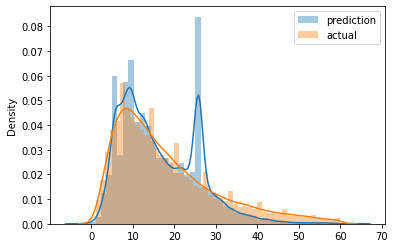

In [164]:
fit_model(LinearRegression(),X_train,y_train,X_test,y_test)

RMSE with Lasso(alpha=0.001) is 9.233436225720547


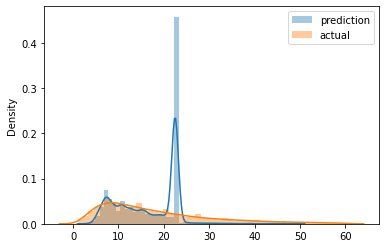

In [165]:
fit_model(Lasso(alpha=0.001),X_train,y_train,X_test,y_test)

RMSE with Ridge() is 11.342603943250333


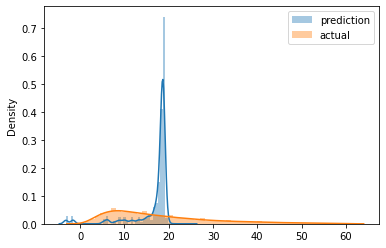

In [167]:
fit_model(Ridge(),X_train,y_train,X_test,y_test)

In [175]:
lr = LinearRegression()
with open('/Users/subramanianhariharan/Documents/kumar_work/mlops/mlops-zoomcamp/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

## 1.6 Homework

Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

1054112
1154112
1254112
1354112

In [177]:
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet

--2022-05-18 12:43:10--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.46.4
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.46.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11886281 (11M) [binary/octet-stream]
Saving to: ‘fhv_tripdata_2021-01.parquet’

fhv_tripdata_2021-0 100%[===================>]  11.33M  9.34MB/s    in 1.2s    

2022-05-18 12:43:12 (9.34 MB/s) - ‘fhv_tripdata_2021-01.parquet’ saved [11886281/11886281]



In [178]:
!wget https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet

--2022-05-18 12:43:40--  https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-02.parquet
Resolving nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)... 52.217.236.9
Connecting to nyc-tlc.s3.amazonaws.com (nyc-tlc.s3.amazonaws.com)|52.217.236.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10645466 (10M) [binary/octet-stream]
Saving to: ‘fhv_tripdata_2021-02.parquet’

fhv_tripdata_2021-0 100%[===================>]  10.15M  12.0MB/s    in 0.8s    

2022-05-18 12:43:41 (12.0 MB/s) - ‘fhv_tripdata_2021-02.parquet’ saved [10645466/10645466]



In [179]:
#function to read df 
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    return df

In [180]:
fhv_jan21 = read_dataframe('fhv_tripdata_2021-01.parquet')
fhv_feb21 = read_dataframe('fhv_tripdata_2021-02.parquet')

In [181]:
fhv_jan21.shape

(1154112, 7)

In [182]:
fhv_feb21.shape

(1037692, 7)

Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

15.16
19.16
24.16
29.16

In [183]:
fhv_jan21.head(3)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013


In [184]:
fhv_jan21.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [187]:
def duration(df):
    df['duration'] = df['dropOff_datetime']-df['pickup_datetime']
    df['duration']=df['duration'].apply(lambda x : x.total_seconds()/60)
    return df

In [188]:
fhv_jan21 = duration(fhv_jan21)
fhv_feb21 = duration(fhv_feb21)

In [189]:
fhv_jan21.head(3)

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.0
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.0
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.0


In [190]:
fhv_jan21['duration'].mean()

19.167224093791006

## Data preparation

Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

In [ ]:
Data preparation

Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

In [194]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [195]:
fhv_jan21['duration'].describe()

count   1154112.000
mean         19.167
std         398.692
min           0.017
25%           7.767
50%          13.400
75%          22.283
max      423371.050
Name: duration, dtype: float64

In [196]:
fhv_feb21['duration'].describe()

count   1037692.000
mean         20.707
std         161.108
min           0.017
25%           8.000
50%          14.100
75%          23.733
max      110919.000
Name: duration, dtype: float64

In [197]:
def filter_df(df):
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    return df

In [198]:
fhv_jan21 = filter_df(fhv_jan21)
fhv_feb21 = filter_df(fhv_feb21)

In [199]:
fhv_jan21.shape,fhv_feb21.shape

((1109826, 8), (990113, 8))

In [201]:
(1154112-1109826), (1037692-990113)

(44286, 47579)

## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

53%
63%
73%
83%

In [203]:
def fill_nas(df):
    #replace missing values  with -1
    df[['PUlocationID', 'DOlocationID']] = df[['PUlocationID', 'DOlocationID']].fillna(value=-1)
    return df

In [204]:
fhv_jan21 = fill_nas(fhv_jan21)
fhv_feb21 = fill_nas(fhv_feb21)

In [207]:
fhv_jan21[fhv_jan21['PUlocationID']== -1].shape[0]/fhv_jan21.shape[0]

0.8352732770722617

### Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix? (The number of columns).

2
152
352
525
725

In [208]:
features = ['PUlocationID', 'DOlocationID']


In [215]:
dv = DictVectorizer()
features = ['PUlocationID', 'DOlocationID']
fhv_jan21[features] = fhv_jan21[features].astype(str)
fhv_feb21[features] = fhv_feb21[features].astype(str)
train_dicts=fhv_jan21[features].to_dict(orient='records')
val_dicts = fhv_feb21[features].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(val_dicts)
y_train = fhv_jan21['duration'].values
y_test = fhv_feb21['duration'].values

In [216]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [217]:
X_test

<990113x525 sparse matrix of type '<class 'numpy.float64'>'
	with 1980223 stored elements in Compressed Sparse Row format>

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters
Calculate the RMSE of the model on the training data
What's the RMSE on train?

5.52
10.52
15.52
20.52

In [218]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
rmse=mean_squared_error(y_train,y_pred,squared=False) #RMSE
print(f'RMSE with training data for {model} is {rmse}')

RMSE with training data for LinearRegression() is 10.528519394661334


## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

6.01
11.01
16.01
21.01

In [219]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
rmse=mean_squared_error(y_test,y_pred,squared=False) #RMSE
print(f'RMSE with validation data for {model} is {rmse}')

RMSE with validation data for LinearRegression() is 11.014286810163442
